In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import shap

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.utils import all_estimators

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
    
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict
import random
from skfp.fingerprints import ECFPFingerprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

from skfp.fingerprints import (
    ECFPFingerprint,
    MACCSFingerprint,
    AtomPairFingerprint,
    TopologicalTorsionFingerprint,
    RDKitFingerprint,
    AvalonFingerprint
)
from sklearn.base import clone
from rdkit.Chem import Descriptors
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import optuna

In [ ]:
import sklearn
print(sklearn.__version__)

In [24]:
pip install scikit-learn==1.2.2

     |████████████████████████████████| 9.1 MB 452 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 12.1 MB 574 kB/s eta 0:00:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('training_data.csv')

print(f"Dataset size: {df.shape}")
print(df.info())

In [3]:
print(df.isnull().sum())

ACTIVITY    0
smiles      0
dtype: int64


In [4]:
class_counts = df['ACTIVITY'].value_counts()
toxic_percent = (df['ACTIVITY'].mean() * 100)

print(class_counts)
print(f"Percentage of toxic (1): {toxic_percent:.2f}%")

/var/folders/ph/1fnt_x611p91ks6bkm_k384c0000gn/T/ipykernel_59192/211853514.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ACTIVITY', data=df, palette='viridis')


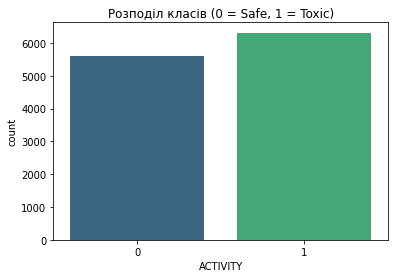

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='ACTIVITY', data=df, palette='viridis')
plt.title('Class distribution (0 = Safe, 1 = Toxic)')
plt.show()

In [6]:
df['smiles_len'] = df['smiles'].astype(str).apply(len)
print(df['smiles_len'].describe())

count    11930.000000
mean        55.089103
std         13.158991
min          8.000000
25%         47.000000
50%         55.000000
75%         63.000000
max        160.000000
Name: smiles_len, dtype: float64


In [7]:
df.head()

,ACTIVITY,smiles,smiles_len
0,1,Fc1ccc(-n2cc(NCCN3CCCCC3)nn2)cc1F,33
1,0,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,51
2,0,CCOC(=O)C1CCC(N2CC(NC(=O)CNc3nn(C(N)=O)c4ccc(C...,65
3,0,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,63
4,0,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,55


In [3]:
def get_scaffold(smiles: str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold, canonical=True)

In [4]:
def scaffold_split(
    df,
    smiles_col="smiles",
    frac_train=0.8,
    seed=42
):
    random.seed(seed)

    scaffold_groups = defaultdict(list)
    for idx, row in df.iterrows():
        scaffold = get_scaffold(row[smiles_col])
        scaffold_groups[scaffold].append(idx)

    scaffolds = list(scaffold_groups.keys())
    random.shuffle(scaffolds)

    train_idx, test_idx = [], []
    n_total = len(df)
    n_train = int(frac_train * n_total)

    for scaffold in scaffolds:
        if len(train_idx) < n_train:
            train_idx.extend(scaffold_groups[scaffold])
        else:
            test_idx.extend(scaffold_groups[scaffold])

    return df.loc[train_idx], df.loc[test_idx]

In [5]:
clean_df = pd.read_csv("training_data.csv")
print(clean_df.columns)

train_df, val_df = scaffold_split(clean_df)

Index(['ACTIVITY', 'smiles'], dtype='object')


In [14]:
print(train_df)
print(val_df)

       ACTIVITY                                             smiles
3974          0        COc1cc(NCC2CCNCC2)nc2c1nnn2-c1cccc(N(C)C)c1
6552          1  FC(F)(F)Oc1cccc(-n2nnc3cc(Cl)c(NCC4CCNCC4)nc32)c1
10066         1    COc1cc(NCC2CCNCC2)nc2c1nnn2-c1cccc(OC(F)(F)F)c1
7189          0               N=C(Nc1ccc2c(c1)CCCN2CCCNCCO)c1cccs1
7200          0                N=C(Nc1ccc2c(c1)CCCN2CCNCCO)c1cccs1
...         ...                                                ...
3282          1      CCN1CCNC(CN2CCN(C(=O)Nc3ccc(Cl)c(Cl)c3)CC2)C1
7327          1  Cc1cccc(C)c1OCC(=O)N[C@H](Cc1ccccc1)[C@H](O)C[...
7871          1  CCN(CC)Cc1cc(C=NN=C(N)CC(O)c2cc3c(F)cc(F)cc3c3...
4765          1      Fc1cc(-c2cc3sc(N4CCC(N5CCCCC5)CC4)nc3cn2)ccn1
6362          1     COc1cc(-c2cc3sc(N4CCC(N5CCCCC5)CC4)nc3cn2)ccn1

[9545 rows x 2 columns]
       ACTIVITY                                             smiles
9884          0  NC1(C(=O)N[C@@H](CCN2CCCCC2)c2ccc(Cl)cc2)CCN(c...
1335          0    Cc1nc2ccncc2c(=O)n

In [11]:
ecfp = ECFPFingerprint(
    fp_size=1024,
    radius=2,
    count=False,
    n_jobs=-1
)

In [12]:
X_train = ecfp.fit_transform(train_df['smiles'])
y_train = train_df['ACTIVITY'].values

X_val = ecfp.transform(val_df['smiles'])
y_val = val_df['ACTIVITY'].values

In [13]:
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]], dtype=uint8),
 array([0, 1, 1, ..., 1, 1, 1]))

In [17]:
def benchmark_models_train_val(
    X_train, y_train,
    X_val, y_val,
    preprocessor,
    target_name,
    output_folder='model_results'
):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    estimators = all_estimators(type_filter='classifier')

    ignored_models = [
        'ClassifierChain', 'MultiOutputClassifier',
        'OneVsOneClassifier', 'OneVsRestClassifier',
        'OutputCodeClassifier', 'VotingClassifier', 'StackingClassifier',
        'GaussianProcessClassifier', 
        'GaussianNB', 'MultinomialNB', 'ComplementNB', 'BernoulliNB', 
        'PassiveAggressiveClassifier', 'Perceptron', 'SGDClassifier', 
        'QuadraticDiscriminantAnalysis', 'RadiusNeighborsClassifier',
        'LabelPropagation', 'LabelSpreading', 
        'DummyClassifier', 'NuSVC', 'SVC' 
    ]

    models_to_test = []

    for name, Class in estimators:
        if name not in ignored_models:
            try:
                params = {}
                if 'random_state' in Class().get_params():
                    params['random_state'] = 42
                if 'n_jobs' in Class().get_params():
                    params['n_jobs'] = -1  

                model = Class(**params)
                models_to_test.append((name, model))
            except Exception:
                pass

    models_to_test.append((
        'XGBoost',
        XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
    ))

    models_to_test.append((
        'LightGBM',
        LGBMClassifier(verbose=-1, random_state=42, n_jobs=-1)
    ))

    results = []
    print(f"--- Starting testing of {len(models_to_test)} models ---")

    for name, model in models_to_test:
        steps = []
        if preprocessor:
            steps.append(('preprocessor', preprocessor))
        steps.append(('classifier', model))
        
        pipe = Pipeline(steps)

        try:
            pipe.fit(X_train, y_train)

            y_train_pred = pipe.predict(X_train)
            y_val_pred = pipe.predict(X_val)

            try:
                y_train_proba = pipe.predict_proba(X_train)[:, 1]
                y_val_proba = pipe.predict_proba(X_val)[:, 1]
            except AttributeError:
                y_train_proba = np.zeros_like(y_train)
                y_val_proba = np.zeros_like(y_val)

            results.append({
                'Model': name,
                
                'Train_ROC_AUC': round(roc_auc_score(y_train, y_train_proba), 4) if np.max(y_train_proba) > 0 else 0,
                'Train_Acc': round(accuracy_score(y_train, y_train_pred), 4),
                'Train_Recall': round(recall_score(y_train, y_train_pred, zero_division=0), 4),
                'Train_Precision': round(precision_score(y_train, y_train_pred, zero_division=0), 4),
                'Train_F1': round(f1_score(y_train, y_train_pred, zero_division=0), 4),

                'Val_ROC_AUC': round(roc_auc_score(y_val, y_val_proba), 4) if np.max(y_val_proba) > 0 else 0,
                'Val_Acc': round(accuracy_score(y_val, y_val_pred), 4),
                'Val_Recall': round(recall_score(y_val, y_val_pred, zero_division=0), 4),
                'Val_Precision': round(precision_score(y_val, y_val_pred, zero_division=0), 4),
                'Val_F1': round(f1_score(y_val, y_val_pred, zero_division=0), 4),
            })
            print(f"[OK] {name}")

        except Exception as e:
            print(f"[ERROR] {name}: {e}")

    df_results = pd.DataFrame(results)
    
    if not df_results.empty:
        df_results = df_results.sort_values(by='Val_ROC_AUC', ascending=False)
        
        filename = f"{output_folder}/Results_{target_name}.xlsx"
        df_results.to_excel(filename, index=False)
        
        print(f"\n--- COMPARISON TRAIN vs VAL (Top 10 Models) ---")
        
        cols = [
            'Model', 
            'Train_ROC_AUC', 'Val_ROC_AUC', 
            'Train_Acc',     'Val_Acc',
            'Train_F1',      'Val_F1'
        ]
        
        print(df_results[cols].head(10).to_string(index=False))
        print(f"\nFull results saved to: {filename}")
    
    return df_results

In [18]:
results = benchmark_models_train_val(
    X_train, y_train, 
    X_val, y_val, 
    preprocessor=None, 
    target_name="ACTIVITY"
)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[OK] CalibratedClassifierCV
[OK] CategoricalNB
[OK] DecisionTreeClassifier
[OK] ExtraTreeClassifier
[OK] ExtraTreesClassifier
[OK] GradientBoostingClassifier
[OK] HistGradientBoostingClassifier
[OK] KNeighborsClassifier
[OK] LinearDiscriminantAnalysis


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[OK] LinearSVC


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[OK] LogisticRegression


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [34]:
def get_fingerprints():
    return {
        "ECFP4": ECFPFingerprint(
            fp_size=512,
            radius=2,
            count=False,
            n_jobs=-1
        ),

        "ECFP6": ECFPFingerprint(
            fp_size=1024,
            radius=3,
            count=False,
            n_jobs=-1
        ),

        "MACCS": MACCSFingerprint(),

        "AtomPair": AtomPairFingerprint(
            fp_size=1024,
            n_jobs=-1
        ),

        "TopologicalTorsion": TopologicalTorsionFingerprint(
            fp_size=1024,
            n_jobs=-1
        ),

        "RDKit": RDKitFingerprint(
            fp_size=1024
        ),

        "Avalon": AvalonFingerprint(
            fp_size=1024,
            n_jobs=-1
        )
    }


In [6]:
def get_models():
    return {
        "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42),
        "ExtraTrees": ExtraTreesClassifier(n_jobs=-1, random_state=42),
        "MLP": MLPClassifier(random_state=42),
        "XGBoost": XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42
        ),
        "LightGBM": LGBMClassifier(random_state=42)
    }

In [9]:
def compute_metrics(y_true, y_pred, y_proba):
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred)
    }

In [10]:
def benchmark_fingerprints(
    train_df,
    val_df,
    smiles_col="smiles",
    target_col="ACTIVITY",
    output_file="fingerprints_benchmark.xlsx"
):
    results = []

    X_train_smiles = train_df[smiles_col].tolist()
    y_train = train_df[target_col].values

    X_val_smiles = val_df[smiles_col].tolist()
    y_val = val_df[target_col].values

    fingerprints = get_fingerprints()
    models = get_models()

    for fp_name, fp in fingerprints.items():
        print(f"\n=== Fingerprint: {fp_name} ===")

        X_train = fp.fit_transform(X_train_smiles)
        X_val = fp.transform(X_val_smiles)

        for model_name, model_template in models.items():
            print(f"  Training model: {model_name}")
            
            model = clone(model_template)

            model.fit(X_train, y_train)

            for split_name, X, y in [
                ("train", X_train, y_train),
                ("val", X_val, y_val)
            ]:
                y_pred = model.predict(X)
                y_proba = model.predict_proba(X)[:, 1]

                metrics = compute_metrics(y, y_pred, y_proba)

                results.append({
                    "Fingerprint": fp_name,
                    "Model": model_name,
                    "Split": split_name,
                    **metrics
                })

    results_df = pd.DataFrame(results)
    results_df.to_excel(output_file, index=False)

    return results_df

In [40]:
results_df = benchmark_fingerprints(
    train_df=train_df,
    val_df=val_df,
    smiles_col="smiles",
    target_col="ACTIVITY",
    output_file="fingerprint_full_benchmark.xlsx"
)


=== Fingerprint: ECFP4 ===
  Training model: RandomForest
  Training model: ExtraTrees
  Training model: MLP
  Training model: XGBoost


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training model: LightGBM

=== Fingerprint: ECFP6 ===
  Training model: RandomForest
  Training model: ExtraTrees
  Training model: MLP
  Training model: XGBoost


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training model: LightGBM

=== Fingerprint: MACCS ===
  Training model: RandomForest
  Training model: ExtraTrees
  Training model: MLP


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training model: XGBoost
  Training model: LightGBM

=== Fingerprint: AtomPair ===
  Training model: RandomForest
  Training model: ExtraTrees
  Training model: MLP
  Training model: XGBoost


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training model: LightGBM

=== Fingerprint: TopologicalTorsion ===
  Training model: RandomForest
  Training model: ExtraTrees
  Training model: MLP
  Training model: XGBoost


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:03:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training model: LightGBM

=== Fingerprint: RDKit ===
  Training model: RandomForest
  Training model: ExtraTrees
  Training model: MLP


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  Training model: XGBoost


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training model: LightGBM

=== Fingerprint: Avalon ===
  Training model: RandomForest
  Training model: ExtraTrees
  Training model: MLP
  Training model: XGBoost


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:04:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training model: LightGBM


In [ ]:
# Descriptors

In [7]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [8]:
def get_descriptors(smiles_list):
    desc_names = [name for name, _ in Descriptors._descList]  
    funcs = [func for _, func in Descriptors._descList]
    data = []

    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            vals = []
            for f in funcs:
                try:
                    vals.append(f(mol))
                except:
                    vals.append(np.nan)
        else:
            vals = [np.nan] * len(desc_names)
        data.append(vals)

    df = pd.DataFrame(data, columns=desc_names)
    return df

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
X_train_desc_raw = get_descriptors(train_df['smiles'])
X_val_desc_raw = get_descriptors(val_df['smiles'])

In [11]:
X_train_desc_raw.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.557047,5.557047,0.656991,0.656991,0.678085,14.964286,381.484,354.268,381.227708,148,...,0,0,0,0,0,0,0,0,0,0
1,12.507864,12.507864,0.341090,-4.777221,0.646302,15.586207,426.830,408.686,426.118272,154,...,0,0,0,0,0,0,0,0,0,0
2,12.560293,12.560293,0.337322,-4.781492,0.631253,15.333333,422.411,401.243,422.167809,160,...,0,0,0,0,0,0,0,0,0,0
3,8.799977,8.799977,0.197225,0.197225,0.332633,13.560000,358.511,332.303,358.182732,134,...,0,0,0,0,0,0,0,1,0,0
4,8.832356,8.832356,0.182355,0.182355,0.353825,13.625000,344.484,320.292,344.167082,128,...,0,0,0,0,0,0,0,1,0,0


In [12]:
is_nan_train = X_train_desc_raw.isna()
is_inf_train = X_train_desc_raw.isin([np.inf, -np.inf])

nan_cols = is_nan_train.sum()
inf_cols = is_inf_train.sum()

bad_cols_train = nan_cols[nan_cols > 0].index.tolist()
bad_inf_cols_train = inf_cols[inf_cols > 0].index.tolist()

print(f"Total rows: {len(X_train_desc_raw)}")
print(f"Columns with NaN: {len(bad_cols_train)}")
if len(bad_cols_train) > 0:
    print(f"Problematic columns (NaN): {bad_cols_train}")

print(f"Columns with Infinity: {len(bad_inf_cols_train)}")
if len(bad_inf_cols_train) > 0:
    print(f"Problematic columns (Inf): {bad_inf_cols_train}")

In [13]:
is_nan_val = X_val_desc_raw.isna()
is_inf_val = X_val_desc_raw.isin([np.inf, -np.inf])

bad_cols_val = is_nan_val.sum()[is_nan_val.sum() > 0].index.tolist()
bad_inf_cols_val = is_inf_val.sum()[is_inf_val.sum() > 0].index.tolist()

print(f"Total rows: {len(X_val_desc_raw)}")
print(f"Columns with NaN: {len(bad_cols_val)}")
if len(bad_cols_val) > 0:
    print(f"Problematic columns: {bad_cols_val}")

In [14]:
X_train_desc = X_train_desc_raw.drop(columns=['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'])
X_val_desc = X_val_desc_raw.drop(columns=['BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'])

In [15]:
is_nan_train = X_train_desc.isna()
is_inf_train = X_train_desc.isin([np.inf, -np.inf])

nan_cols = is_nan_train.sum()
inf_cols = is_inf_train.sum()

bad_cols_train = nan_cols[nan_cols > 0].index.tolist()
bad_inf_cols_train = inf_cols[inf_cols > 0].index.tolist()

print(f"Total rows: {len(X_train_desc_raw)}")
print(f"Columns with NaN: {len(bad_cols_train)}")
if len(bad_cols_train) > 0:
    print(f"Problematic columns (NaN): {bad_cols_train}")

print(f"Columns with Infinity: {len(bad_inf_cols_train)}")
if len(bad_inf_cols_train) > 0:
    print(f"Problematic columns (Inf): {bad_inf_cols_train}")

In [16]:
selector = VarianceThreshold(threshold=0)

selector.fit(X_train_desc)

cols_kept = X_train_desc.columns[selector.get_support()]

X_train_var = X_train_desc[cols_kept]
X_val_var = X_val_desc[cols_kept]

print(f"   Remaining descriptors: {X_train_var.shape[1]}")
print(f"   Removed constants: {X_train_desc.shape[1] - X_train_var.shape[1]}")

In [17]:
corr_matrix = X_train_var.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]

print(f"   Found correlated (clones): {len(to_drop)}")

In [21]:
X_train_final = X_train_var.drop(columns=to_drop)
X_val_final = X_val_var.drop(columns=to_drop)
print(f"\nFinal number of descriptors: {X_train_final.shape[1]}")

In [22]:
scaler = StandardScaler()

X_train_desc_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final), 
    columns=X_train_final.columns
)

X_val_desc_scaled = pd.DataFrame(
    scaler.transform(X_val_final), 
    columns=X_val_final.columns
)

y_train = train_df['ACTIVITY'].values

y_val = val_df['ACTIVITY'].values

In [23]:
def train_and_evaluate_with_importance(
    models_dict, 
    X_train, y_train, 
    X_val, y_val, 
    feature_names=None
):
    results = []
    
    if feature_names is None:
        try:
            feature_names = X_train.columns.tolist()
        except:
            feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

    for name, model_template in models_dict.items():
        print(f"\n{'='*20} {name} {'='*20}")
        
        model = clone(model_template)
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred   = model.predict(X_val)
        
        try:
            y_train_proba = model.predict_proba(X_train)[:, 1]
            y_val_proba   = model.predict_proba(X_val)[:, 1]
        except:
            y_train_proba = np.zeros(len(y_train))
            y_val_proba   = np.zeros(len(y_val))

        res = {
            'Model': name,
            'Val_AUC':       round(roc_auc_score(y_val, y_val_proba), 4),
            'Val_F1':        round(f1_score(y_val, y_val_pred), 4),
            'Val_Recall':    round(recall_score(y_val, y_val_pred), 4),
            'Val_Precision': round(precision_score(y_val, y_val_pred), 4),
            'Val_Acc':       round(accuracy_score(y_val, y_val_pred), 4),
            'Train_AUC':     round(roc_auc_score(y_train, y_train_proba), 4),
            'Train_F1':      round(f1_score(y_train, y_train_pred), 4)
        }
        results.append(res)
        print(f"{name}: AUC={res['Val_AUC']} | F1={res['Val_F1']} | Recall={res['Val_Recall']}")

        if hasattr(model, 'feature_importances_'):
            try:
                importances = model.feature_importances_
                
                feat_imp = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importances
                })
                
                feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)
                
                plt.figure(figsize=(10, 6))
                plt.barh(feat_imp['Feature'][::-1], feat_imp['Importance'][::-1], color='skyblue')
                plt.xlabel("Importance Score")
                plt.title(f"Top 20 Features - {name}")
                plt.tight_layout()
                plt.show()
                
                print(f"TOP-10 features:")
                print(feat_imp[['Feature', 'Importance']].head(10).to_string(index=False))
                
            except Exception as e:
                print(f"Failed to output importance: {e}")
        else:
            print(f"Model {name} does not support feature_importances_ (e.g., MLP)")

    df_res = pd.DataFrame(results).sort_values(by='Val_AUC', ascending=False)
    
    print("\n\nSUMMARY TABLE:")
    cols = ['Model', 'Val_AUC', 'Val_F1', 'Val_Recall', 'Train_AUC', 'Train_F1']
    print(df_res[cols].to_string(index=False))
    
    return df_res


==================== RandomForest ====================
RandomForest: AUC=0.8844 | F1=0.8273 | Recall=0.8097


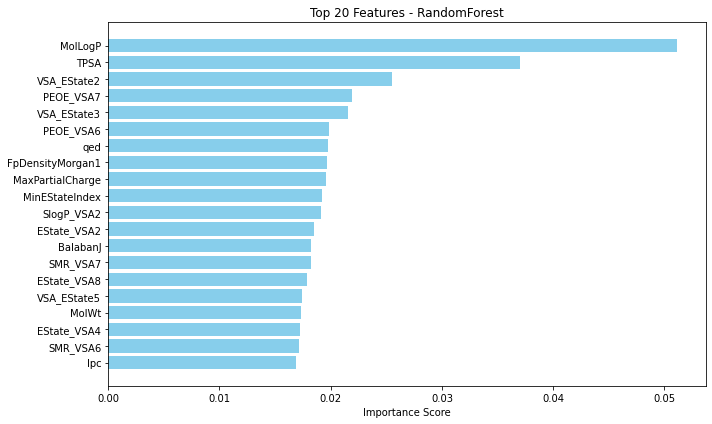

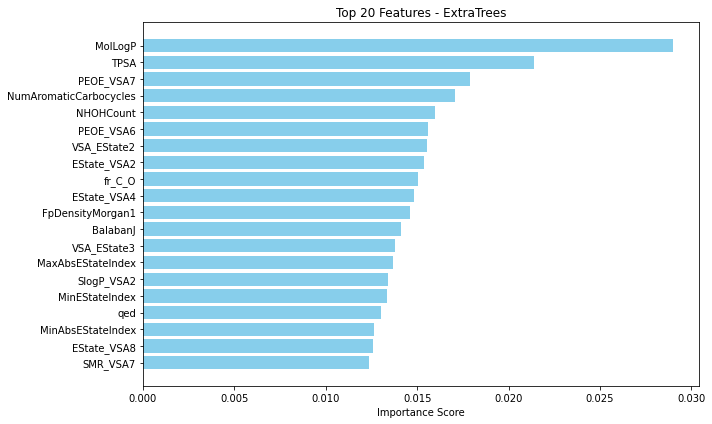

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


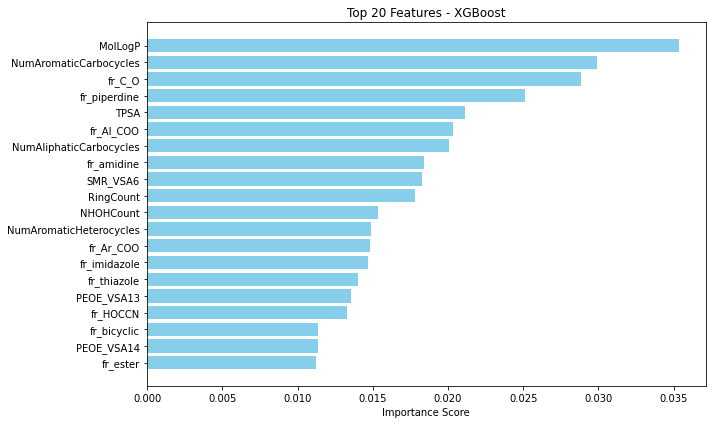

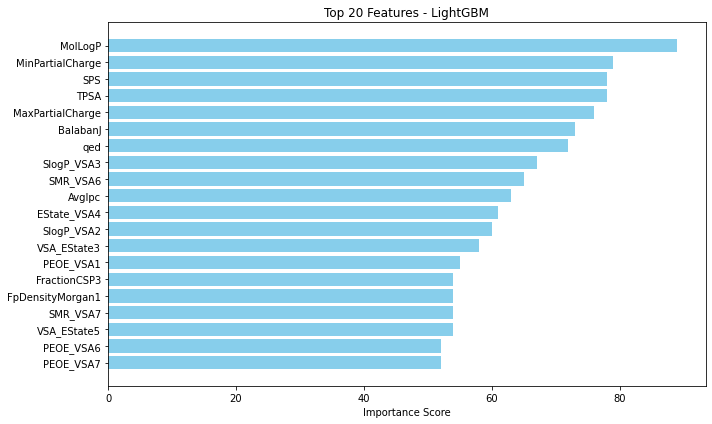

In [24]:
feature_names_list = X_train_desc_scaled.columns.tolist()

metrics_df = train_and_evaluate_with_importance(
    get_models(),          
    X_train_desc_scaled,   
    y_train,               
    X_val_desc_scaled,     
    y_val,                 
    feature_names=feature_names_list
)

In [34]:
avalon_gen = AvalonFingerprint(fp_size=1024, n_jobs=-1)
X_train_avalon_np = avalon_gen.transform(train_df['smiles'])
X_val_avalon_np   = avalon_gen.transform(val_df['smiles'])

X_train_avalon = pd.DataFrame(X_train_avalon_np, columns=[f"Avalon_{i}" for i in range(1024)])
X_val_avalon   = pd.DataFrame(X_val_avalon_np,   columns=[f"Avalon_{i}" for i in range(1024)])

maccs_gen = MACCSFingerprint(n_jobs=-1)

X_train_maccs_np = maccs_gen.transform(train_df['smiles'])
X_val_maccs_np   = maccs_gen.transform(val_df['smiles'])

n_maccs = X_train_maccs_np.shape[1] 

maccs_cols = [f"MACCS_{i}" for i in range(n_maccs)]

X_train_maccs = pd.DataFrame(X_train_maccs_np, columns=maccs_cols)
X_val_maccs   = pd.DataFrame(X_val_maccs_np,   columns=maccs_cols)

In [35]:
def create_hybrid(fp_df, desc_df):
    return pd.concat([fp_df.reset_index(drop=True), 
                      desc_df.reset_index(drop=True)], axis=1)


X_train_A = create_hybrid(X_train_avalon, X_train_desc_scaled)
X_val_A   = create_hybrid(X_val_avalon, X_val_desc_scaled)

X_train_B = create_hybrid(X_train_maccs, X_train_desc_scaled)
X_val_B   = create_hybrid(X_val_maccs, X_val_desc_scaled)

y_train = train_df['ACTIVITY'].values
y_val = val_df['ACTIVITY'].values

In [36]:
def train_evaluate_save(models_dict, X_train, y_train, X_val, y_val, group_name):
    results = []
    for name, model_template in models_dict.items():
        
        model = clone(model_template)
        model.fit(X_train, y_train)
        
        y_val_pred   = model.predict(X_val)
        y_train_pred = model.predict(X_train)
        
        try:
            y_val_proba   = model.predict_proba(X_val)[:, 1]
            y_train_proba = model.predict_proba(X_train)[:, 1]
        except:
            y_val_proba   = np.zeros(len(y_val))
            y_train_proba = np.zeros(len(y_train))

        results.append({
            'Model': name,
            'Fingerprint': group_name,
            'Val_AUC':       round(roc_auc_score(y_val, y_val_proba), 4),
            'Val_F1':        round(f1_score(y_val, y_val_pred), 4),
            'Val_Recall':    round(recall_score(y_val, y_val_pred), 4),
            'Val_Precision': round(precision_score(y_val, y_val_pred), 4),
            'Val_Acc':       round(accuracy_score(y_val, y_val_pred), 4),
            'Train_AUC':     round(roc_auc_score(y_train, y_train_proba), 4),
            'Train_F1':      round(f1_score(y_train, y_train_pred), 4)
        })
    return results

In [37]:
models_group_A = {
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_jobs=-1, random_state=42),
    "MLP": MLPClassifier(random_state=42, max_iter=500)
}

models_group_B = {
    "XGBoost": XGBClassifier(n_jobs=-1, random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1)
}

all_results = []

res_A = train_evaluate_save(models_group_A, X_train_A, y_train, X_val_A, y_val, "Avalon")
all_results.extend(res_A)

res_B = train_evaluate_save(models_group_B, X_train_B, y_train, X_val_B, y_val, "MACCS")
all_results.extend(res_B)

df_final = pd.DataFrame(all_results).sort_values(by='Val_AUC', ascending=False)
df_final.to_excel("Final_Hybrid_Results_SKFP.xlsx", index=False)

print("\n\nFINAL TABLE:")
print(df_final[['Model', 'Fingerprint', 'Val_AUC', 'Val_F1', 'Val_Recall']].to_string(index=False))

In [57]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial, model_name, X_train, y_train, X_val, y_val):
    
    if model_name == "RandomForest":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 25),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': True,
            'n_jobs': -1,
            'random_state': 42
        }
        model = RandomForestClassifier(**params)

    elif model_name == "ExtraTrees":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': False,
            'n_jobs': -1,
            'random_state': 42
        }
        model = ExtraTreesClassifier(**params)

    elif model_name == "MLP":
        layers_option = trial.suggest_categorical('layers', [
            (100,), (200,), (100, 50), (200, 100), (128, 64, 32)
        ])
        params = {
            'hidden_layer_sizes': layers_option,
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
            'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
            'max_iter': 500,
            'random_state': 42,
            'early_stopping': True
        }
        model = MLPClassifier(**params)

    elif model_name == "XGBoost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
            'eval_metric': 'logloss',
            'n_jobs': -1,
            'random_state': 42,
            'use_label_encoder': False,
            'early_stopping_rounds': 50  
        }
        model = XGBClassifier(**params)

    elif model_name == "LightGBM":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'verbose': -1,
            'n_jobs': -1,
            'random_state': 42,
            'early_stopping_rounds': 50
        }
        model = LGBMClassifier(**params)
    
    if model_name == "XGBoost":
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
    elif model_name == "LightGBM":
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
        )
    else:
        model.fit(X_train, y_train)

    try:
        y_val_proba = model.predict_proba(X_val)[:, 1]
    except:
        return 0.5
        
    score = roc_auc_score(y_val, y_val_proba)
    return score

In [58]:
tasks = [
    ("RandomForest", X_train_A, X_val_A),
    ("ExtraTrees",   X_train_A, X_val_A),
    ("MLP",          X_train_A, X_val_A),
    ("XGBoost",      X_train_B, X_val_B),
    ("LightGBM",     X_train_B, X_val_B)
]

best_params_dict = {}
trials_count = 30 

for model_name, X_tr, X_v in tasks:
    print(f"\nOptimizing {model_name}...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name, X_tr, y_train, X_v, y_val), n_trials=trials_count)
    
    print(f"Best AUC: {study.best_value:.4f}")
    print(f"Params: {study.best_params}")
    
    best_params_dict[model_name] = study.best_params


Optimizing RandomForest...
Best AUC: 0.8933
Params: {'n_estimators': 379, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

Optimizing ExtraTrees...
Best AUC: 0.8830
Params: {'n_estimators': 394, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}

Optimizing MLP...


/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (200,) which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50) which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

Best AUC: 0.8833
Params: {'layers': (200,), 'activation': 'relu', 'alpha': 3.1186447778076576e-05, 'learning_rate_init': 0.000811366296934043}

Optimizing XGBoost...


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:15:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:15:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:15:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/x

Best AUC: 0.8935
Params: {'n_estimators': 704, 'max_depth': 8, 'learning_rate': 0.05661179119583111, 'subsample': 0.8385057032670211, 'colsample_bytree': 0.7012470564638917, 'reg_alpha': 2.076669803419995, 'reg_lambda': 5.121367414009656, 'scale_pos_weight': 2.207345013424333}

Optimizing LightGBM...
Best AUC: 0.8921
Params: {'n_estimators': 369, 'num_leaves': 82, 'learning_rate': 0.08429717594222487, 'min_child_samples': 49, 'reg_alpha': 0.2374029842447758, 'reg_lambda': 6.448139090375375, 'subsample': 0.8357811132614095, 'colsample_bytree': 0.7636711325624201}


In [59]:
final_results = []

for model_name, X_tr, X_v in tasks:
    best_params = best_params_dict[model_name].copy()
    
    if model_name == "MLP":
        if 'layers' in best_params:
            best_params['hidden_layer_sizes'] = best_params.pop('layers')
            
        model = MLPClassifier(**best_params, max_iter=500, random_state=42, early_stopping=True)

    elif model_name == "RandomForest":
        model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42, bootstrap=True)
        
    elif model_name == "ExtraTrees":
        model = ExtraTreesClassifier(**best_params, n_jobs=-1, random_state=42, bootstrap=False)
        
    elif model_name == "XGBoost":
        model = XGBClassifier(**best_params, n_jobs=-1, random_state=42, 
                              eval_metric='logloss', use_label_encoder=False)
        
    elif model_name == "LightGBM":
        model = LGBMClassifier(**best_params, n_jobs=-1, random_state=42, verbose=-1)
    
    if model_name == "XGBoost":
        model.fit(X_tr, y_train, eval_set=[(X_v, y_val)], verbose=False)
    elif model_name == "LightGBM":
        model.fit(X_tr, y_train, eval_set=[(X_v, y_val)])
    else:
        model.fit(X_tr, y_train)
        
    y_val_proba = model.predict_proba(X_v)[:, 1]
    y_val_pred = model.predict(X_v)
    y_train_pred = model.predict(X_tr)
    try:
        y_train_proba = model.predict_proba(X_tr)[:, 1]
    except:
        y_train_proba = np.zeros(len(y_train))

    from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

    res = {
        'Model': model_name,
        'Best_Params': str(best_params),
        'Val_AUC': round(roc_auc_score(y_val, y_val_proba), 4),
        'Val_F1':  round(f1_score(y_val, y_val_pred), 4),
        'Val_Recall': round(recall_score(y_val, y_val_pred), 4),
        'Val_Precision': round(precision_score(y_val, y_val_pred), 4),
        'Train_AUC': round(roc_auc_score(y_train, y_train_proba), 4),
        'Train_F1':  round(f1_score(y_train, y_train_pred), 4)
    }
    final_results.append(res)

df_opt_final = pd.DataFrame(final_results).sort_values(by='Val_F1', ascending=False)
df_opt_final.to_excel("Optimized_Results_Final_auc.xlsx", index=False)

print("\n\nFINAL RESULTS:")
print(df_opt_final[['Model', 'Val_F1', 'Val_Recall', 'Val_AUC']].to_string(index=False))

/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:20:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [54]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial, model_name, X_train, y_train, X_val, y_val):
    
    if model_name == "RandomForest":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 25),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': True,
            'n_jobs': -1,
            'random_state': 42
        }
        model = RandomForestClassifier(**params)

    elif model_name == "ExtraTrees":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': False,
            'n_jobs': -1,
            'random_state': 42
        }
        model = ExtraTreesClassifier(**params)

    elif model_name == "MLP":
        layers_option = trial.suggest_categorical('layers', [
            (100,), (200,), (100, 50), (200, 100), (128, 64, 32)
        ])
        params = {
            'hidden_layer_sizes': layers_option,
            'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
            'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
            'max_iter': 500,
            'random_state': 42,
            'early_stopping': True
        }
        model = MLPClassifier(**params)

    elif model_name == "XGBoost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0), # Critical for F1 with imbalance
            'eval_metric': 'logloss',
            'n_jobs': -1,
            'random_state': 42,
            'use_label_encoder': False,
            'early_stopping_rounds': 50  
        }
        model = XGBClassifier(**params)

    elif model_name == "LightGBM":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'verbose': -1,
            'n_jobs': -1,
            'random_state': 42,
            'early_stopping_rounds': 50
        }
        model = LGBMClassifier(**params)
    
    if model_name == "XGBoost":
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
    elif model_name == "LightGBM":
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
        )
    else:
        model.fit(X_train, y_train)
        
    y_val_pred = model.predict(X_val)
    
    score = f1_score(y_val, y_val_pred)
    return score

In [55]:
tasks = [
    ("RandomForest", X_train_A, X_val_A),
    ("ExtraTrees",   X_train_A, X_val_A),
    ("MLP",          X_train_A, X_val_A),
    ("XGBoost",      X_train_B, X_val_B),
    ("LightGBM",     X_train_B, X_val_B)
]

best_params_dict = {}
trials_count = 30 

for model_name, X_tr, X_v in tasks:
    print(f"\nOptimizing {model_name}...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_name, X_tr, y_train, X_v, y_val), n_trials=trials_count)
    
    print(f"F1 AUC: {study.best_value:.4f}")
    print(f"Params: {study.best_params}")
    
    best_params_dict[model_name] = study.best_params


Optimizing RandomForest...
F1 AUC: 0.8456
Params: {'n_estimators': 455, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Optimizing ExtraTrees...
F1 AUC: 0.8416
Params: {'n_estimators': 490, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Optimizing MLP...


/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (200,) which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50) which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

F1 AUC: 0.8346
Params: {'layers': (100,), 'activation': 'relu', 'alpha': 7.128482513405885e-05, 'learning_rate_init': 0.002251441123545675}

Optimizing XGBoost...


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:51:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:51:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/x

F1 AUC: 0.8532
Params: {'n_estimators': 557, 'max_depth': 10, 'learning_rate': 0.018759726530095465, 'subsample': 0.8651284416863974, 'colsample_bytree': 0.6025521278261444, 'reg_alpha': 2.660794174357434, 'reg_lambda': 0.19721908113890763, 'scale_pos_weight': 2.78688039553108}

Optimizing LightGBM...
F1 AUC: 0.8457
Params: {'n_estimators': 523, 'num_leaves': 55, 'learning_rate': 0.04279918714895313, 'min_child_samples': 28, 'reg_alpha': 2.4479271474918063, 'reg_lambda': 3.0683482438014984, 'subsample': 0.6849403709948632, 'colsample_bytree': 0.7571179313857305}


In [56]:
final_results = []

for model_name, X_tr, X_v in tasks:
    best_params = best_params_dict[model_name].copy()
    
    if model_name == "MLP":
        if 'layers' in best_params:
            best_params['hidden_layer_sizes'] = best_params.pop('layers')
            
        model = MLPClassifier(**best_params, max_iter=500, random_state=42, early_stopping=True)

    elif model_name == "RandomForest":
        model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42, bootstrap=True)
        
    elif model_name == "ExtraTrees":
        model = ExtraTreesClassifier(**best_params, n_jobs=-1, random_state=42, bootstrap=False)
        
    elif model_name == "XGBoost":
        model = XGBClassifier(**best_params, n_jobs=-1, random_state=42, 
                              eval_metric='logloss', use_label_encoder=False)
        
    elif model_name == "LightGBM":
        model = LGBMClassifier(**best_params, n_jobs=-1, random_state=42, verbose=-1)
    
    if model_name == "XGBoost":
        model.fit(X_tr, y_train, eval_set=[(X_v, y_val)], verbose=False)
    elif model_name == "LightGBM":
        model.fit(X_tr, y_train, eval_set=[(X_v, y_val)])
    else:
        model.fit(X_tr, y_train)
        
    y_val_proba = model.predict_proba(X_v)[:, 1]
    y_val_pred = model.predict(X_v)
    y_train_pred = model.predict(X_tr)
    try:
        y_train_proba = model.predict_proba(X_tr)[:, 1]
    except:
        y_train_proba = np.zeros(len(y_train))

    from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

    res = {
        'Model': model_name,
        'Best_Params': str(best_params),
        'Val_AUC': round(roc_auc_score(y_val, y_val_proba), 4),
        'Val_F1':  round(f1_score(y_val, y_val_pred), 4),
        'Val_Recall': round(recall_score(y_val, y_val_pred), 4),
        'Val_Precision': round(precision_score(y_val, y_val_pred), 4),
        'Train_AUC': round(roc_auc_score(y_train, y_train_proba), 4),
        'Train_F1':  round(f1_score(y_train, y_train_pred), 4)
    }
    final_results.append(res)

df_opt_final = pd.DataFrame(final_results).sort_values(by='Val_F1', ascending=False)
df_opt_final.to_excel("Optimized_Results_Final.xlsx", index=False)

print("\n\nFINAL RESULTS:")
print(df_opt_final[['Model', 'Val_F1', 'Val_Recall', 'Val_AUC']].to_string(index=False))

/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:59:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
